<a href="https://colab.research.google.com/github/S-abk/GA_TSP/blob/main/ACO_TSP_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Ant Colony Optimization for Traveling Salesman Problem



## Introduction

This report details the implementation of the Ant Colony Optimization (ACO) algorithm to solve the Traveling Salesman Problem (TSP).



### The Traveling Salesman Problem (TSP)

The Traveling Salesman Problem (TSP) is a classic optimization problem. The objective is to find the shortest possible route that visits each city exactly once and returns to the original city. Formally, given \( n \) cities and the distances \( d_{ij} \) between each pair of cities \( i \) and \( j \), the objective is to minimize:

$$
\text{Objective:} \quad \min \left( \sum_{i=1}^{n} d_{\pi(i),\pi(i+1)} + d_{\pi(n),\pi(1)} \right)
$$

### Ant Colony Optimization (ACO)

Ant Colony Optimization (ACO) is a probabilistic technique useful for solving computational problems which can be reduced to finding good paths through graphs.

#### Algorithm Components

The ACO algorithm for the TSP involves several key components:

1. **Pheromone Levels**: $( tau_{ij} )$ represents the amount of pheromone on the path from city $( i )$ to city $( j )$.
2. **Distance**: $( d_{ij} )$ is the distance between cities $(i)$ and $(j)$.
3. **Ant Solutions**: Each ant constructs a solution to the problem based on some probabilistic rules.
4. **Pheromone Update**: The pheromone levels are updated according to the quality of the solutions found.

#### Solution Construction

Each ant constructs a solution $(S)$ based on a probabilistic rule defined as:

$$
P_{ij} = \frac{\tau_{ij}^\alpha \times \left( \frac{1}{d_{ij}} \right)^\beta}{\sum_{k \in \text{Allowed}} \tau_{ik}^\alpha \times \left( \frac{1}{d_{ik}} \right)^\beta}
$$

Here, $( P_{ij} )$ is the probability of moving from city $(i)$ to city $(j)$, $( \alpha)$ and $(\beta)$ are parameters that control the relative importance of the pheromone and the distance, and "Allowed" is the set of cities that have not been visited yet.

#### Pheromone Update

The pheromone levels are updated using the formula:

$$[
\tau_{ij} = (1 - \rho) \times \tau_{ij} + \Delta \tau_{ij}
]$$

In this equation, $(\rho)$ is the pheromone evaporation rate, and $(\Delta\tau_{ij})$ is the amount of pheromone to be deposited, often calculated as $(\frac{Q}{L})$, where $( Q)$ is a constant and $(L)$ is the length of the tour.


## Solution Design



### Importing Necessary Modules

First, we import all the necessary modules.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from concurrent.futures import ProcessPoolExecutor


### Function Definitions

#### Generating Cities

We represent cities and the distances between them using NumPy arrays. Specifically, each city is represented by its (x, y) coordinates, and we use a 2D distance matrix to represent distances between each pair of cities.



In [13]:
number_of_cities = 25  #Change number of cities to visit

def generate_cities(num_cities):
    return np.random.rand(num_cities, 2) * 200


#### Calculating Distance Matrix

Here, we calculate the distance matrix using the `distance_matrix` function from the `scipy.spatial` module.



In [14]:
def calculate_distance_matrix(cities_coords):
    return distance_matrix(cities_coords, cities_coords)


#### Constructing Solutions for Ants

The solution space is encoded as an array of city indices representing the order in which an ant visits the cities.


In [15]:
def construct_solution(ant, pheromones, distance_matrix, alpha, beta):
    num_cities = len(distance_matrix)
    path = [np.random.randint(num_cities)]  # Start from a random city
    available_cities = set(range(num_cities)) - {path[0]}
    for i in range(num_cities - 1):
        current_city = path[-1]
        probabilities = [
            (pheromones[current_city][next_city]**alpha) *
            ((1 / distance_matrix[current_city][next_city])**beta)
            for next_city in available_cities
        ]
        probabilities /= np.sum(probabilities)
        next_city = np.random.choice(list(available_cities), p=probabilities)
        path.append(next_city)
        available_cities.remove(next_city)
    return path


#### Calculating Path Length


In [16]:
def path_length(path, distance_matrix):
    return np.sum([distance_matrix[path[i]][path[i + 1]] for i in range(len(path) - 1)]) + \
           distance_matrix[path[-1]][path[0]]



#### 2-Opt Optimization

We use the 2-opt algorithm as a local optimization strategy to improve the best solution found by the ants.



In [17]:
def two_opt(route, distance_matrix):
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                if j - i == 1: continue  # changes nothing, skip then
                if distance_matrix[best[i-1]][best[i]] + distance_matrix[best[j-1]][best[j]] > \
                        distance_matrix[best[i-1]][best[j-1]] + distance_matrix[best[i]][best[j]]:
                    best[i:j] = best[j-1:i-1:-1]
                    improved = True
    route = best
    return route


#### Helper Function for Parallelization




In [18]:
def construct_solution_helper(args):
    return construct_solution(*args)


#### Main ACO Function

The main ACO function orchestrates the entire algorithm.


In [19]:
def aco_tsp(num_ants, num_iterations, alpha, beta, rho, Q):
    # Generate random cities and calculate the distance matrix
    cities_coords = generate_cities(number_of_cities)
    distance_matrix = calculate_distance_matrix(cities_coords)

    # Initialize pheromones
    pheromones = np.ones((len(cities_coords), len(cities_coords)))

    # Best path and length initialization
    best_path = None
    best_length = np.inf

    # Run the ACO algorithm
    for iteration in range(num_iterations):
        # Construct solutions for each ant in parallel
        with ProcessPoolExecutor() as executor:
            all_paths = list(executor.map(
                construct_solution_helper,
                [(ant, pheromones, distance_matrix, alpha, beta) for ant in range(num_ants)]
            ))
        # Calculate the lengths of all paths
        all_lengths = np.array([path_length(path, distance_matrix) for path in all_paths])

        # Update the best path and length if necessary
        if np.min(all_lengths) < best_length:
            best_length = np.min(all_lengths)
            best_path = all_paths[np.argmin(all_lengths)]

        # Update pheromones
        pheromones *= (1 - rho)  # Evaporation
        for path, length in zip(all_paths, all_lengths):
            for i in range(len(path) - 1):
                pheromones[path[i]][path[i + 1]] += Q / length
            pheromones[path[-1]][path[0]] += Q / length  # Closing the loop

    # Apply 2-opt optimization to the best path
    best_path_optimized = two_opt(best_path, distance_matrix)

    return best_path_optimized, path_length(best_path_optimized, distance_matrix), cities_coords



### Handling the Initial Ant Population

The initial ant population is created by starting each ant at a randomly selected city. This is done in the `construct_solution` function.



### Updating Pheromone Trails

The pheromone trails are updated after all ants complete their paths. The pheromones are updated based on the quality of the paths and a pheromone evaporation rate (\(
ho \)).



### Computing the Best Solution

The best solution is kept track of during each iteration. If an ant finds a shorter path than the current best path, the best path and its length are updated.



### Stopping Condition

The algorithm runs for a pre-defined number of iterations (`num_iterations`). This is a simple and effective stopping condition for the problem.



### Additional Parameters and Design Choices

- `alpha` and `beta` control the importance of pheromones and distances, respectively.
- `rho` is the pheromone evaporation rate.
- `Q` is a constant used in pheromone updates.
- Parallelization is used for constructing solutions for ants, making the algorithm faster.


In [44]:
# Set parameters
num_ants = 40
num_iterations = 100
alpha = 8
beta = 2
rho = 0.5
Q = 1



## Visualization

The program concludes by plotting the best-found path using Matplotlib.


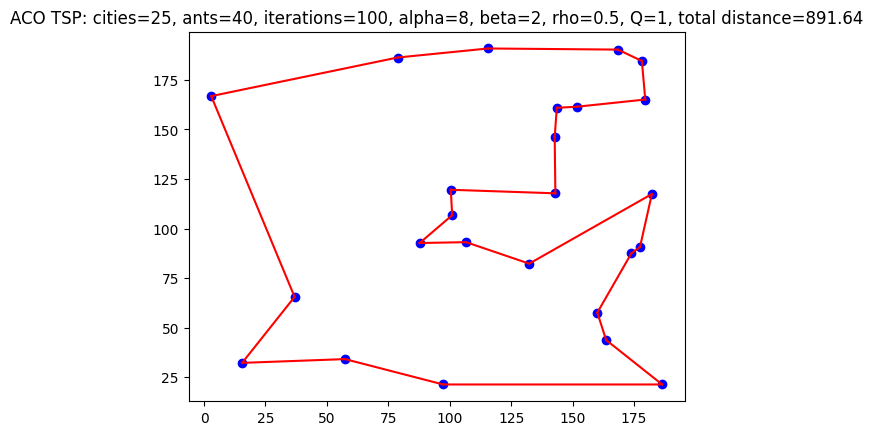

In [45]:
# Run the ACO TSP
best_path, best_length, cities_coords = aco_tsp(num_ants, num_iterations, alpha, beta, rho, Q)

# Plot the cities and the shortest path
plt.scatter(cities_coords[:, 0], cities_coords[:, 1], color='blue')
for i in range(len(best_path) - 1):
    plt.plot(*zip(*cities_coords[best_path[i:i+2]]), color='red')
plt.plot(*zip(*cities_coords[[best_path[-1], best_path[0]]]), color='red')  # Closing the loop

# Add parameters to the plot
num_cities = len(cities_coords)
plt.title(f'ACO TSP: cities={num_cities}, ants={num_ants}, iterations={num_iterations}, alpha={alpha}, beta={beta}, rho={rho}, Q={Q}, total distance={best_length:.2f}')

plt.show()


## Conclusion


Ant Colony Optimization provides a flexible and effective mechanism for solving the Traveling Salesman Problem. By simulating the foraging behavior of ants, the algorithm explores the solution space and often converges to a good approximation of the optimal solution. The algorithm's behavior can be fine-tuned through parameters like $( \alpha)$, $(\beta)$, and $(\rho )$.
The ACO algorithm effectively finds a good solution for the TSP. The implementation is scalable and can be parallelized for efficiency.


##References

1. Zhou, Ying, et al. "An adaptive ant colony optimization algorithm for solving the large-scale traveling salesman problem." Computational Intelligence and Neuroscience, vol. 2021, Hindawi, 2021, doi:10.1155/2021/6666206.

2. Li, Wei, and Shifeng Yang. "A Novel Game-Based Ant Colony Optimization Algorithm for the Traveling Salesman Problem." Computational Intelligence and Neuroscience, vol. 2020, Hindawi, 2020, doi:10.1155/2020/8852042.

3. Li, Xiaonan, and Shuai Su. "An improved ant colony optimization algorithm with adaptive heuristic factor for traveling salesman problem." Computational Intelligence and Neuroscience, vol. 2020, Hindawi, 2020, doi:10.1155/2020/8856265.

4. Zhang, Ke, and Xiaobing Wu. "A hybrid symbiotic organisms search and ant colony optimization algorithm for the traveling salesman problem." Computational Intelligence and Neuroscience, vol. 2019, Hindawi, 2019, doi:10.1155/2019/6052750.

5. "Parallel Ant Colony Optimization for the Traveling Salesman Problem with Synchronous and Asynchronous Implementations." Parallel Processing and Applied Mathematics, Springer, 2018, link.springer.com/chapter/10.1007/978-3-319-78054-2_38.

6. Lukas Schneider. "Ant Colony Optimization for the Traveling Salesman Problem." GitHub, https://github.com/LukasSchneider92/AntColonyOptimization-TSP.


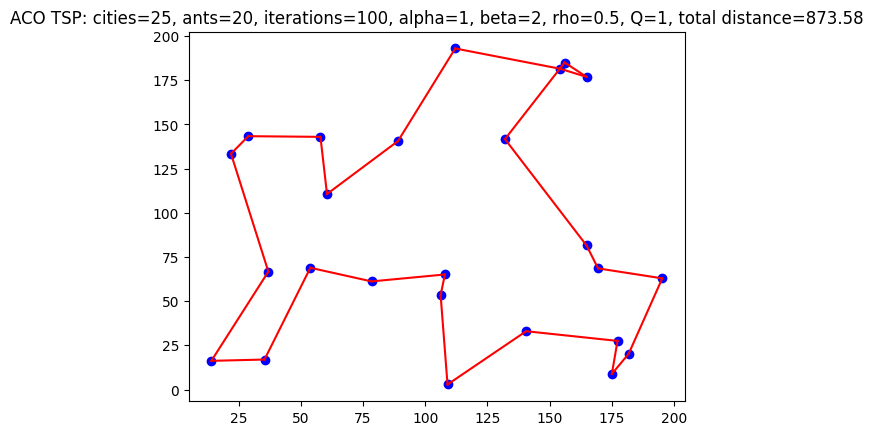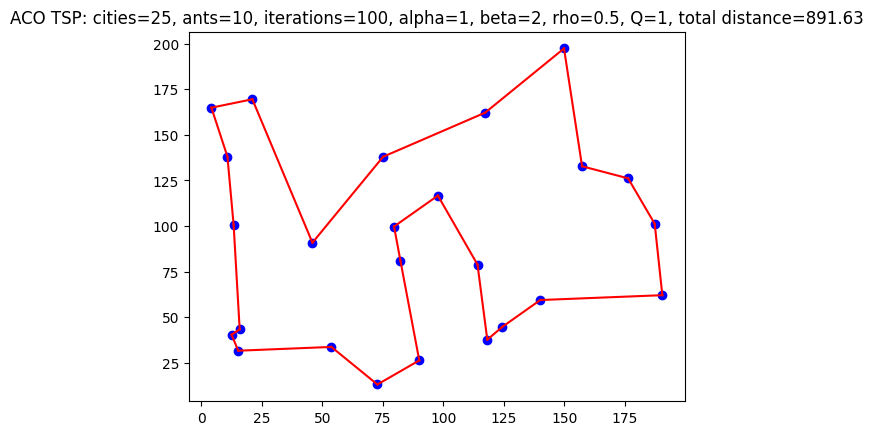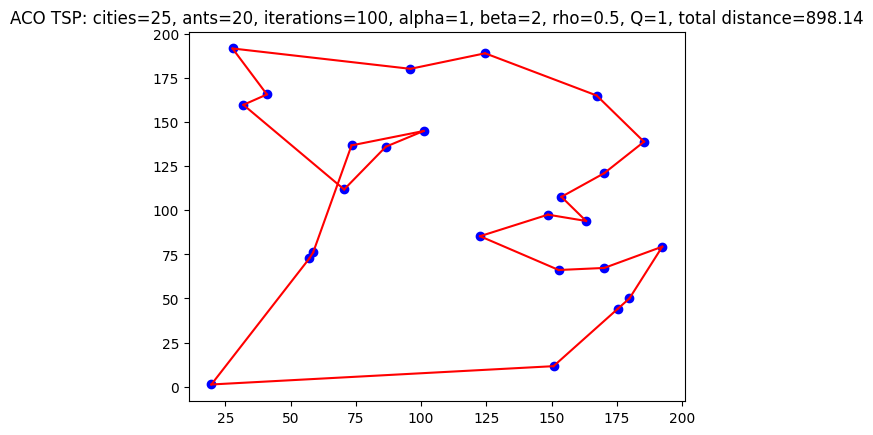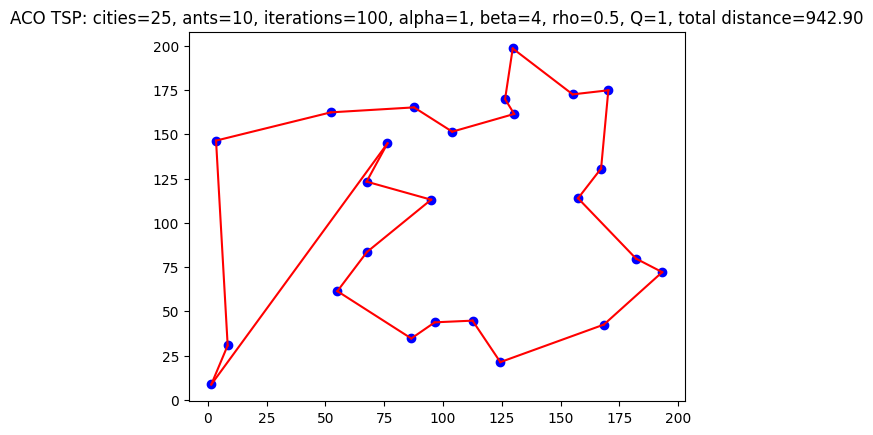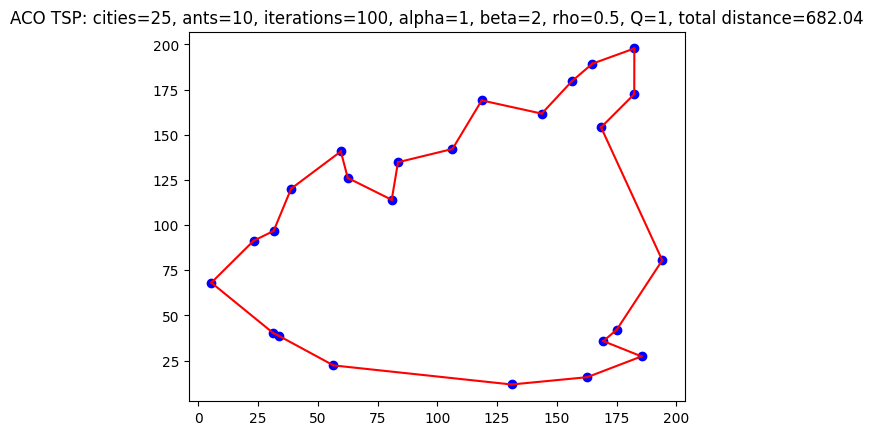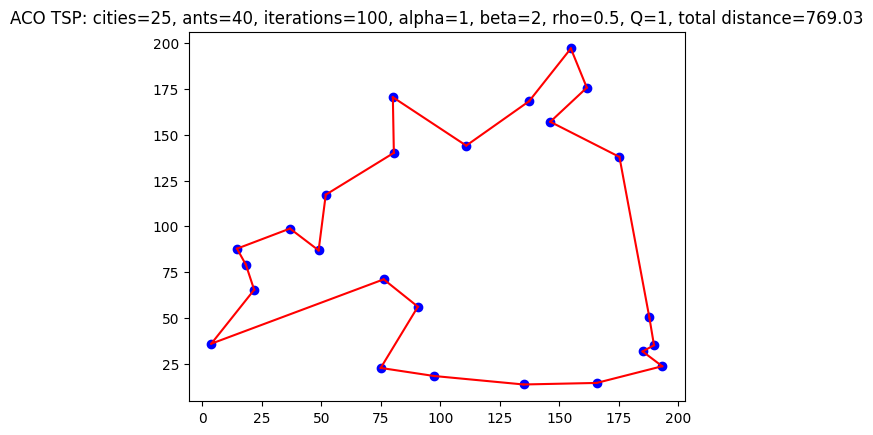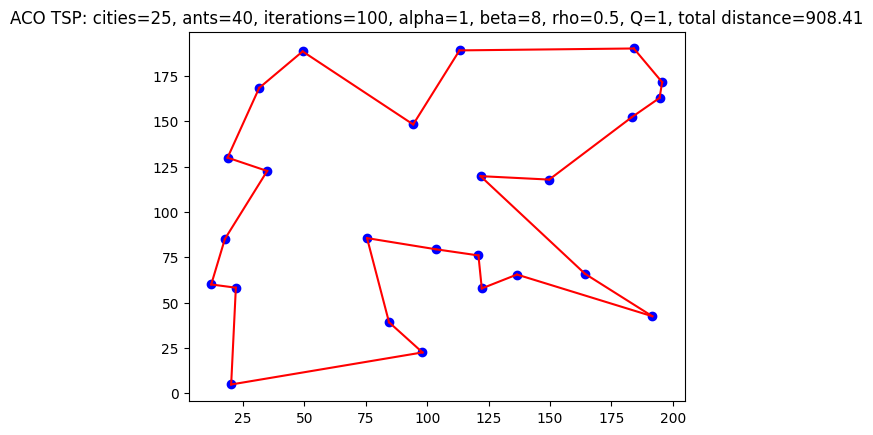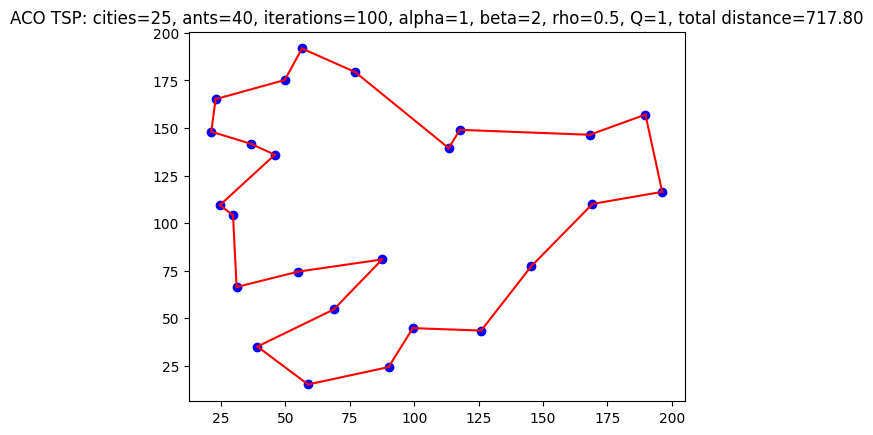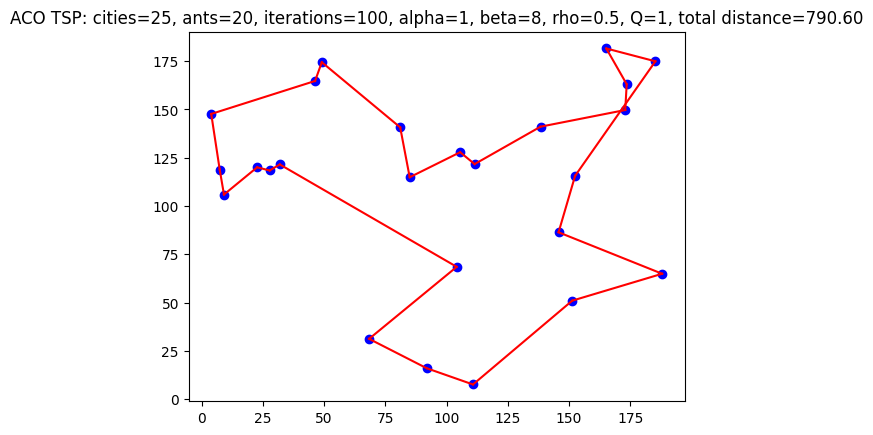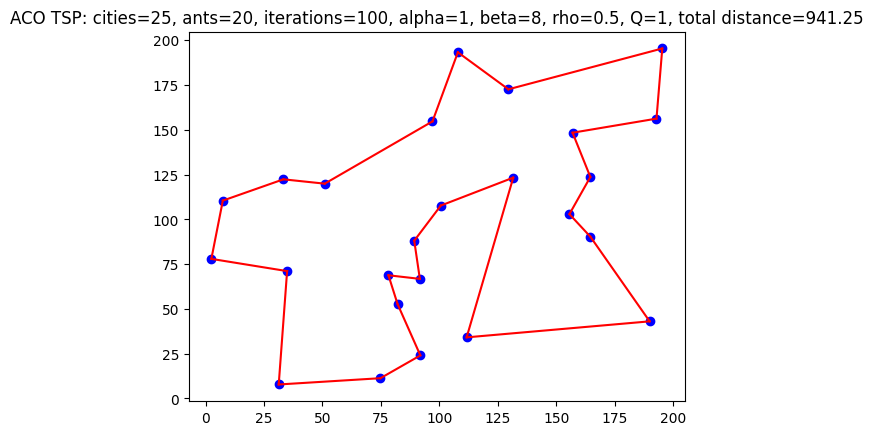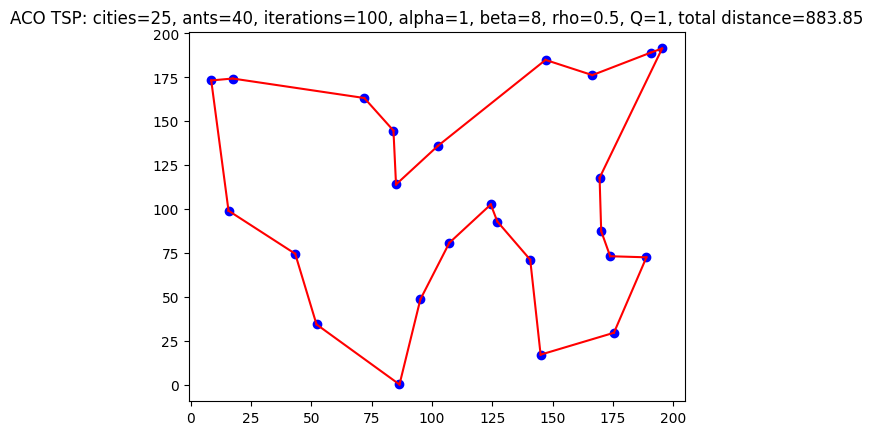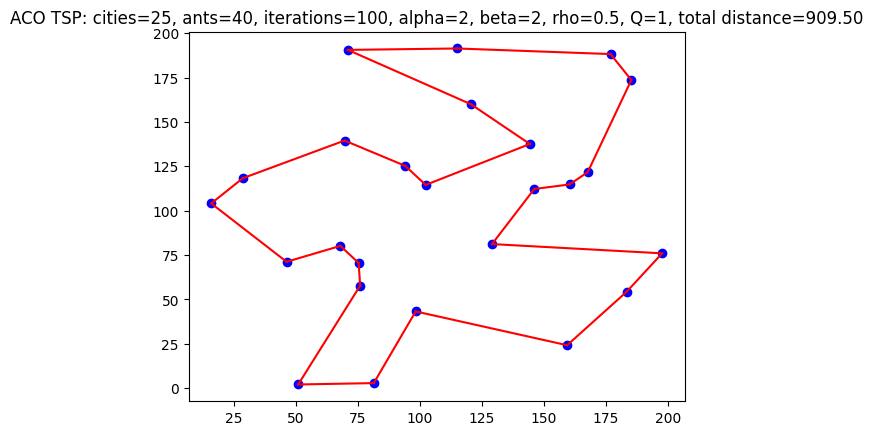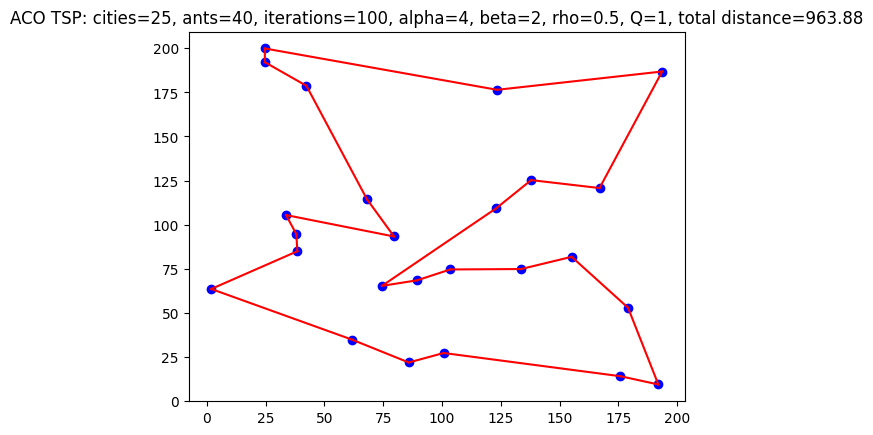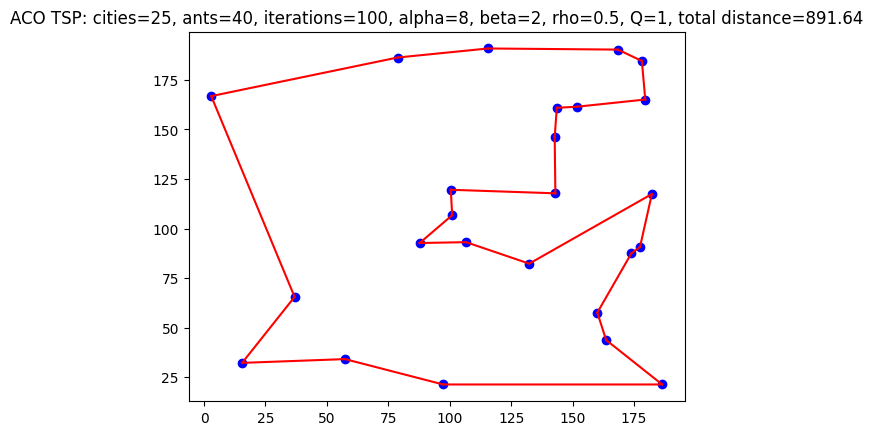